In [18]:
import warnings
import time
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as T

# from dask.distributed import Client
# from dask_gateway import GatewayCluster

import pystac_client
import planetary_computer as pc


import sys
import os

current_folder = os.getcwd()
sys.path.insert(0, '/home/jovyan/sdm-geolifeCLEF/raster')
sys.path.insert(0, '/home/jovyan/sdm-geolifeCLEF/models')

from inception_env import InceptionEnv

from torch.optim.lr_scheduler import MultiStepLR

import sys
for path in sys.path:
    print(path)
print(current_folder)    

/home/jovyan/sdm-geolifeCLEF/models
/home/jovyan/sdm-geolifeCLEF/raster
/home/jovyan/sdm-geolifeCLEF/models
/home/jovyan/sdm-geolifeCLEF/raster
/home/jovyan/sdm-geolifeCLEF/training
/srv/conda/envs/notebook/lib/python39.zip
/srv/conda/envs/notebook/lib/python3.9
/srv/conda/envs/notebook/lib/python3.9/lib-dynload

/srv/conda/envs/notebook/lib/python3.9/site-packages
/home/jovyan/sdm-geolifeCLEF/training


In [10]:
%load_ext autoreload

In [11]:
%autoreload 2
from zarr_dataset import Zarr_Dataset

# Read Zarr Dataset

## KDE

In [35]:
BUCKET_NAME = 'datasets-sdm2'
folder_f = 'geoLifeCLEF/features'
folder_l = 'geoLifeCLEF/labels'
# s3://datasets-sdm2/geoLifeCLEF/features/
filename_train = 'train_ca.zarr'
filename_val_f   = 'val_ca.zarr'
filename_val_l   = 'ca_val_obs_val.zarr'
s3_train_path  = 's3://{}/{}/{}'.format(BUCKET_NAME, folder_f, filename_train)
s3_val_path_f    = 's3://{}/{}/{}'.format(BUCKET_NAME, folder_f, filename_val_f)
s3_val_path_l    = 's3://{}/{}/{}'.format(BUCKET_NAME, folder_l, filename_val_l)
local_val_path = '../data/val_ca.zarr'
local_train_path = '../data/train_ca.zarr'
s3_example_path = 's3://{}/{}/example.zarr'.format(BUCKET_NAME, folder_f)
print(s3_train_path, s3_val_path_f, s3_val_path_l, s3_example_path, local_val_path, local_train_path)

s3://datasets-sdm2/geoLifeCLEF/features/train_ca.zarr s3://datasets-sdm2/geoLifeCLEF/features/val_ca.zarr s3://datasets-sdm2/geoLifeCLEF/labels/ca_val_obs_val.zarr s3://datasets-sdm2/geoLifeCLEF/features/example.zarr ../data/val_ca.zarr ../data/train_ca.zarr


## Setup Train dataset and dataloader

In [5]:
# train_dataset = Zarr_Dataset(s3_train_path)
train_dataset = Zarr_Dataset(local_train_path)

In [6]:
train_dataset.data.info

Type,zarr.core.Array
Data type,object
Shape,"(17173, 2)"
Chunk shape,"(10, 2)"
Order,C
Read-only,True
Filter [0],Pickle(protocol=5)
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Synchronizer type,zarr.sync.ThreadSynchronizer
Store type,zarr.storage.DirectoryStore
No. bytes,274768 (268.3K)


### Quick test

In [7]:
demo = train_dataset[-1]

In [8]:
demo = train_dataset[-1]
N_LABELS = demo[1].shape[0]
N_INPUTS = demo[0].shape[0]
N_LABELS, N_INPUTS

(5079, 31)

## Setup Validation dataset and dataloader

## Validate 

Ascertain accuracy of models

Load model from memory

In [5]:
def TrainAccuracyTopK(predictions, labels, k:int=30, one_hot:bool=True):

    """Returns a '1' for every time a value in the top-k of predicitons is present in the 
       top-k of labels. This is then normalized by the number of predictions
       results can have a maximum value of 1.0
       params:
           - predictions: tensor of [batch_size, num_classes]
           - labels: tensor of [batch_size, num_classes]
    """
    
    res = 0.
    batch_size = labels.shape[0]
    
    
    
    for i, pred in enumerate(predictions):
        top_k_preds = np.argpartition(pred,-k)[-k:]
        
        if not one_hot:
            top_k_labels = np.argpartition(labels[i],-k)[-k:]

            if top_k_preds in top_k_labels:
                res += 1.
        else:
            # There's only one-winner for 1 hot encoded
            # top_k_labels = np.argpartition(labels[i],-1)[-1:]
            top_k_labels = np.argmax(labels[i])
            
            if top_k_labels in top_k_preds:
                res += 1.
                # print("[{}] top_k label = {} | top_k preds = {}".format(i,top_k_labels,top_k_preds))
                # print (res, labels.shape[0])
    return res / labels.shape[0]

In [6]:
def predict(model, loader, device, batch_size, validation_size=-1):
    """
        Give the prediction of the model on a test set
        :param model: the model
        :param test_loader: the test set loader
        :param validation_size: number of occurrences for the validation
    """
    
    validation_size = validation_size / batch_size if validation_size > -1 else -1
    
    with torch.no_grad():
        
        model.eval()

        y_preds = []
        y_labels = []
        count = 0
        
        for inputs, labels in tqdm(loader, leave=False):
            
            y_labels.extend(labels)
            
            # inputs, labels = inputs.type(torch.cuda.FloatTensor).to(device), labels.to(device)
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            
            # if(count % 100 == 0):
            #     print(outputs.shape, outputs.dtype)
                
            y_preds.extend(outputs.cpu())

            # y_preds.extend(outputs.cpu().tolist())
            # y_preds.extend(outputs.data.tolist())
            # y_labels.extend(labels)

            count += 1
            if validation_size > -1 and count >= validation_size:
                break

        predictions, labels = np.asarray(y_preds, dtype=object), np.asarray(y_labels, dtype=object)

    return predictions, labels

In [7]:
from tqdm.notebook import tqdm
def validate (num_epochs, model, device, loader, batch_size=32, validation_size=-1, top_k=[30]):
    
    # model = model.to(device)
    
    for epoch in tqdm(range(num_epochs)):

        predictions, labels = predict(model, loader, device,batch_size, validation_size)

        # evatuate
        res = []
        for k in top_k:
            acc = TrainAccuracyTopK(predictions, labels, k)
            res.append(acc*100.)
            print("Accuracy[top_k={}] = {:.4}%".format(k,res[-1]))

### Load val dataset into memory from s3

In [8]:
BUCKET_NAME = 'datasets-sdm'
folder_f = 'geoLifeCLEF/features'
folder_l = 'geoLifeCLEF/labels'

filename_val_f   = 'val_ca.zarr'
filename_val_l   = 'ca_val_obs_val.zarr'

s3_val_path_f    = 's3://{}/{}/{}'.format(BUCKET_NAME, folder_f, filename_val_f)
s3_val_path_l    = 's3://{}/{}/{}'.format(BUCKET_NAME, folder_l, filename_val_l)
s3_val_path_f, s3_val_path_l

('s3://datasets-sdm/geoLifeCLEF/features/val_ca.zarr',
 's3://datasets-sdm/geoLifeCLEF/labels/ca_val_obs_val.zarr')

In [12]:
%%time
val_dataset = Zarr_Dataset(s3_val_path_f, s3_val_path_l, persist=True)
# val_dataset = Zarr_Dataset(s3_example_path)

CPU times: user 24.4 s, sys: 4.63 s, total: 29 s
Wall time: 3min 59s


In [13]:
val_dataset.features.shape, val_dataset.labels.shape

((5025,), (5025,))

In [58]:
len(val_dataset)

5025

### Load into val dataloader

In [14]:
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=True, batch_size=64, num_workers=4)

### Display datasets

In [60]:
%%time
# (patch, target) = train_set[2708]
(patch, target) = val_dataset[2708]

CPU times: user 28.1 ms, sys: 8 ms, total: 36.1 ms
Wall time: 12.1 ms


In [61]:
patch[4:,:,:].max(), patch[4:,:,:].min(), patch[0:3,:,:].max(), patch[0:3,:,:].min(), patch[3,:,:].max(), patch[3,:,:].min(), len(target)

(tensor(0.8316),
 tensor(0.),
 tensor(0.8706),
 tensor(0.0196),
 tensor(0.3333),
 tensor(0.0030),
 5079)

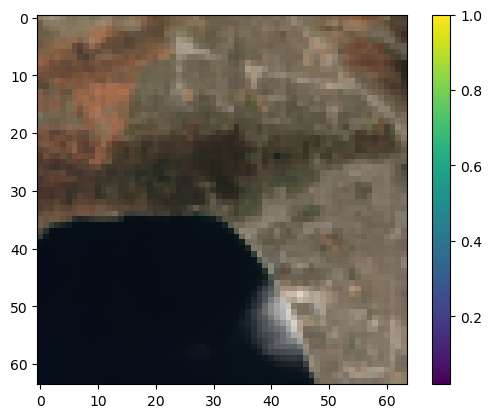

In [62]:
img = patch[0:3,:,:]
plt.imshow(img.permute(1, 2, 0), vmax=1)
plt.colorbar()
plt.show()

(tensor(0.3333), tensor(0.3333))

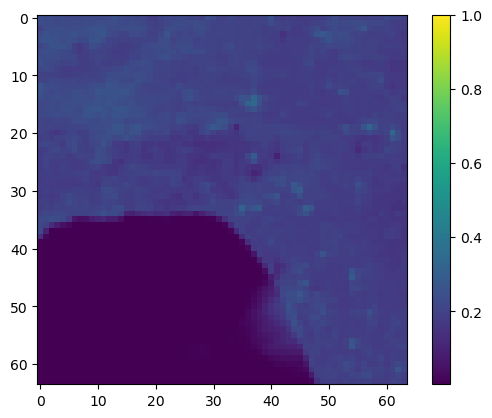

In [53]:
NIR_image = patch[3].unsqueeze(dim=0)#-> Remove first dim (channel) 
plt.imshow(NIR_image.permute(1, 2, 0),vmax=1)#, vmax=1.0)
plt.colorbar()
NIR_image.max(), patch[3].max()

(tensor(0.0030), tensor(0.3333))

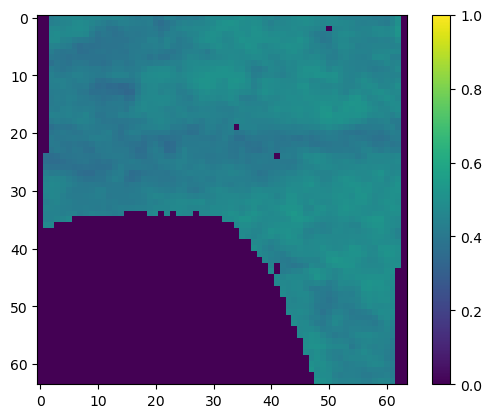

In [52]:
ped = patch[-1].unsqueeze(dim=0)#-> Remove first dim (channel) 
plt.imshow(ped.permute(1, 2, 0),vmax=1)#, vmax=1.0)
plt.colorbar()
patch[3].min(), patch[3].max()

# Train/predict setup

## Train the model

In [21]:
# from train import fit
# from predict import predict
from evaluation import evaluate
from metrics import ValidationAccuracyMultipleBySpecies
from metrics import ValidationAccuracyMultiple


BATCH_SIZE = 128
NUM_WORKERS = 8


iterations = [20,40,60,80,100,120,140,160,180,200]
#test
# iterations = [1]
NUM_EPOCHS = iterations[-1]

LOG_MODULO = 50 #
VAL_MODULO = 5
LR = 0.1
# LR = 1e-2
# LR = 5e-4 * batch_size / 256
GAMMA = 0.1
DROPOUT = 0.7

MODEL = 'inet'
OPTIM = 'SGD'

# evaluation
# METRICS = (ValidationAccuracyMultipleBySpecies([30]), ValidationAccuracyMultiple([30]))
METRICS = (ValidationAccuracyMultiple([30,50]))

In [13]:
import gc
# inet.to('cpu')
# del inet
# del train_set#, val_set
# del train_loader#, val_loader
# del val_dataset, val_loader
gc.collect()

70

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [15]:
most_recent_loss = None
train_loss = []
completed_epochs = 0

In [16]:
inet = InceptionEnv(dropout=DROPOUT, n_labels=N_LABELS, n_input=N_INPUTS)
inet

InceptionNet in mlmc mode

In [18]:
criterion = torch.nn.CrossEntropyLoss()


if OPTIM == 'SGD':
    optimizer = torch.optim.SGD(inet.parameters(), lr=LR, momentum=0.9)
else:
    optimizer = torch.optim.AdamW(inet.parameters(), lr=LR, betas=(0.9, 0.95), weight_decay=0.1)

scheduler = MultiStepLR(optimizer, milestones=iterations, gamma=GAMMA)


In [19]:
from tqdm.notebook import tqdm
import time

def train(model, train_loader, val_loader, num_epochs, criterion, optimizer, scheduler=None, val_modul0=1, completed_epochs=0):
    
    print('beginning to train model')
    model = model.to(device)
    
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0
        start_time = time.perf_counter()
        for inputs, labels in tqdm(train_loader, leave=False):
            # print("Train loop dtypes: ", inputs.dtype, labels.dtype)
            inputs, labels = inputs.type(torch.cuda.FloatTensor).to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
         
        completed_epochs += 1
        
        if scheduler:
            scheduler.step()
            
        end_time = time.perf_counter()
        duration = end_time - start_time
        #train_acc = compute_accuracy(model, train_loader)
        # val_acc = compute_accuracy(model, val_loader)
        
        train_loss.append(running_loss / len(train_loader))
        
        most_recent_loss = train_loss[-1]
        
        if val_loader and epoch % val_modulo == 0:
            validate(1, model, val_loader, device, validation_size=1000)
        
        
        print("Epoch: {0:02d} | Training Loss: {1:.5f} | Time: {2:.3f}".format(epoch+1, most_recent_loss, duration))
        

In [21]:
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

/srv/conda/envs/notebook/lib/python3.9/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [22]:
len(train_loader)

135

In [23]:
train(model=inet, train_loader=train_loader, val_loader=None, num_epochs=NUM_EPOCHS, criterion=criterion, optimizer=optimizer, scheduler=scheduler)
# train(inet, train_loader, None, NUM_EPOCHS, criterion, optimizer)

beginning to train model


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 01 | Training Loss: 1996.23592 | Time: 197.487


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 02 | Training Loss: 1984.67221 | Time: 202.769


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 03 | Training Loss: 1975.29345 | Time: 203.049


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 04 | Training Loss: 1974.63852 | Time: 203.485


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 05 | Training Loss: 1978.09706 | Time: 203.299


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 06 | Training Loss: 1970.71549 | Time: 203.397


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 07 | Training Loss: 1960.90512 | Time: 203.532


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 08 | Training Loss: 1976.78044 | Time: 203.417


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 09 | Training Loss: 1964.65507 | Time: 203.805


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 10 | Training Loss: 1959.74023 | Time: 204.131


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 11 | Training Loss: 1972.01115 | Time: 203.274


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 12 | Training Loss: 1961.13026 | Time: 203.316


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 13 | Training Loss: 1959.50600 | Time: 203.464


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 14 | Training Loss: 1957.39620 | Time: 203.356


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 15 | Training Loss: 1962.74386 | Time: 203.553


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 16 | Training Loss: 1960.53589 | Time: 203.755


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 17 | Training Loss: 1956.32304 | Time: 203.660


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 18 | Training Loss: 1961.29159 | Time: 203.329


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 19 | Training Loss: 1954.50177 | Time: 203.301


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 20 | Training Loss: 1952.81807 | Time: 203.538


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 21 | Training Loss: 1948.50399 | Time: 203.535


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 22 | Training Loss: 1949.92031 | Time: 203.538


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 23 | Training Loss: 1952.29489 | Time: 203.816


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 24 | Training Loss: 1950.20143 | Time: 203.894


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 25 | Training Loss: 1949.61184 | Time: 203.745


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 26 | Training Loss: 1950.54789 | Time: 203.540


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 27 | Training Loss: 1952.61365 | Time: 203.303


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 28 | Training Loss: 1951.17500 | Time: 203.143


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 29 | Training Loss: 1950.15046 | Time: 203.082


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 30 | Training Loss: 1951.01758 | Time: 203.224


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 31 | Training Loss: 1950.54184 | Time: 203.402


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 32 | Training Loss: 1945.90243 | Time: 202.999


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 33 | Training Loss: 1949.66304 | Time: 203.717


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 34 | Training Loss: 1946.51554 | Time: 203.527


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 35 | Training Loss: 1946.35013 | Time: 203.771


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 36 | Training Loss: 1953.04233 | Time: 203.691


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 37 | Training Loss: 1947.32064 | Time: 203.687


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 38 | Training Loss: 1944.11482 | Time: 204.121


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 39 | Training Loss: 1951.60433 | Time: 203.747


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 40 | Training Loss: 1949.72523 | Time: 203.654


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 41 | Training Loss: 1945.99057 | Time: 203.846


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 42 | Training Loss: 1953.82548 | Time: 203.609


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 43 | Training Loss: 1942.98573 | Time: 203.071


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 44 | Training Loss: 1950.56166 | Time: 203.593


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 45 | Training Loss: 1945.15229 | Time: 203.266


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 46 | Training Loss: 1946.19504 | Time: 203.668


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 47 | Training Loss: 1954.36960 | Time: 203.399


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 48 | Training Loss: 1947.27075 | Time: 203.724


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 49 | Training Loss: 1943.83474 | Time: 203.559


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 50 | Training Loss: 1943.56402 | Time: 203.048


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 51 | Training Loss: 1942.27116 | Time: 204.178


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 52 | Training Loss: 1945.49802 | Time: 203.429


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 53 | Training Loss: 1944.71137 | Time: 203.469


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 54 | Training Loss: 1948.81141 | Time: 203.828


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 55 | Training Loss: 1942.64957 | Time: 203.522


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 56 | Training Loss: 1942.99599 | Time: 203.550


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 57 | Training Loss: 1943.86288 | Time: 203.531


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 58 | Training Loss: 1950.24179 | Time: 203.724


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 59 | Training Loss: 1945.06934 | Time: 203.976


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 60 | Training Loss: 1944.65847 | Time: 203.504


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 61 | Training Loss: 1946.49551 | Time: 203.746


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 62 | Training Loss: 1942.79318 | Time: 203.703


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 63 | Training Loss: 1943.15174 | Time: 203.820


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 64 | Training Loss: 1944.47488 | Time: 203.627


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 65 | Training Loss: 1944.23172 | Time: 203.747


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 66 | Training Loss: 1941.03518 | Time: 203.797


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 67 | Training Loss: 1943.78206 | Time: 203.124


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 68 | Training Loss: 1944.23249 | Time: 203.373


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 69 | Training Loss: 1950.62105 | Time: 203.979


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 70 | Training Loss: 1941.43927 | Time: 203.586


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 71 | Training Loss: 1943.15555 | Time: 203.754


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 72 | Training Loss: 1946.22964 | Time: 203.538


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 73 | Training Loss: 1948.55039 | Time: 203.723


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 74 | Training Loss: 1948.42471 | Time: 203.549


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 75 | Training Loss: 1952.53818 | Time: 203.376


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 76 | Training Loss: 1945.22323 | Time: 203.681


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 77 | Training Loss: 1945.56784 | Time: 203.730


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 78 | Training Loss: 1945.91719 | Time: 203.175


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 79 | Training Loss: 1945.72899 | Time: 203.835


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 80 | Training Loss: 1945.11552 | Time: 203.908


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 81 | Training Loss: 1941.50364 | Time: 203.759


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 82 | Training Loss: 1946.62300 | Time: 203.739


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 83 | Training Loss: 1944.47023 | Time: 203.622


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 84 | Training Loss: 1948.28819 | Time: 203.921


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 85 | Training Loss: 1939.91200 | Time: 203.863


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 86 | Training Loss: 1945.11013 | Time: 203.551


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 87 | Training Loss: 1943.42083 | Time: 203.736


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 88 | Training Loss: 1949.58775 | Time: 203.370


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 89 | Training Loss: 1945.42269 | Time: 203.789


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 90 | Training Loss: 1951.22682 | Time: 203.040


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 91 | Training Loss: 1948.17799 | Time: 204.258


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 92 | Training Loss: 1950.93641 | Time: 203.214


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 93 | Training Loss: 1948.18837 | Time: 204.007


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 94 | Training Loss: 1942.89888 | Time: 203.437


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 95 | Training Loss: 1950.51205 | Time: 203.660


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 96 | Training Loss: 1944.60494 | Time: 202.808


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 97 | Training Loss: 1950.12409 | Time: 203.682


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 98 | Training Loss: 1942.51225 | Time: 203.792


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 99 | Training Loss: 1943.83540 | Time: 203.720


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 100 | Training Loss: 1940.92091 | Time: 203.792


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 101 | Training Loss: 1948.01051 | Time: 203.210


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 102 | Training Loss: 1947.03029 | Time: 203.841


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 103 | Training Loss: 1946.56360 | Time: 203.799


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 104 | Training Loss: 1938.16931 | Time: 204.185


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 105 | Training Loss: 1942.86896 | Time: 203.702


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 106 | Training Loss: 1945.49886 | Time: 203.451


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 107 | Training Loss: 1953.25696 | Time: 203.687


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 108 | Training Loss: 1943.62340 | Time: 203.474


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 109 | Training Loss: 1942.06387 | Time: 203.467


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 110 | Training Loss: 1943.32224 | Time: 203.677


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 111 | Training Loss: 1945.54574 | Time: 204.035


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 112 | Training Loss: 1946.41359 | Time: 203.942


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 113 | Training Loss: 1945.12736 | Time: 204.102


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 114 | Training Loss: 1945.03632 | Time: 203.964


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 115 | Training Loss: 1947.35172 | Time: 203.542


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 116 | Training Loss: 1940.13108 | Time: 203.237


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 117 | Training Loss: 1945.45601 | Time: 203.405


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 118 | Training Loss: 1941.76371 | Time: 203.572


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 119 | Training Loss: 1943.28866 | Time: 203.379


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 120 | Training Loss: 1944.61551 | Time: 203.566


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 121 | Training Loss: 1946.57805 | Time: 202.930


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 122 | Training Loss: 1946.94247 | Time: 203.429


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 123 | Training Loss: 1949.86774 | Time: 203.321


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 124 | Training Loss: 1944.65487 | Time: 203.717


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 125 | Training Loss: 1941.18101 | Time: 203.850


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 126 | Training Loss: 1951.17374 | Time: 204.263


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 127 | Training Loss: 1946.28198 | Time: 203.400


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 128 | Training Loss: 1939.60450 | Time: 203.750


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 129 | Training Loss: 1948.63282 | Time: 203.690


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 130 | Training Loss: 1944.35521 | Time: 203.917


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 131 | Training Loss: 1945.57422 | Time: 203.730


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 132 | Training Loss: 1940.74769 | Time: 203.615


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 133 | Training Loss: 1944.09378 | Time: 203.787


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 134 | Training Loss: 1949.30062 | Time: 203.905


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 135 | Training Loss: 1943.74453 | Time: 203.703


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 136 | Training Loss: 1947.51709 | Time: 203.739


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 137 | Training Loss: 1948.28236 | Time: 203.671


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 138 | Training Loss: 1947.93611 | Time: 204.073


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 139 | Training Loss: 1944.87558 | Time: 203.810


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 140 | Training Loss: 1947.49817 | Time: 203.586


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 141 | Training Loss: 1949.37754 | Time: 204.186


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 142 | Training Loss: 1940.03027 | Time: 203.822


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 143 | Training Loss: 1949.55201 | Time: 203.621


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 144 | Training Loss: 1946.23748 | Time: 203.616


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 145 | Training Loss: 1948.63381 | Time: 203.925


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 146 | Training Loss: 1944.59610 | Time: 203.432


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 147 | Training Loss: 1942.80796 | Time: 203.788


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 148 | Training Loss: 1943.03701 | Time: 203.620


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 149 | Training Loss: 1943.19466 | Time: 203.770


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 150 | Training Loss: 1946.36005 | Time: 203.706


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 151 | Training Loss: 1948.02405 | Time: 203.300


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 152 | Training Loss: 1950.24865 | Time: 203.655


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 153 | Training Loss: 1945.11761 | Time: 203.509


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 154 | Training Loss: 1943.73851 | Time: 203.615


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 155 | Training Loss: 1950.32327 | Time: 203.738


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 156 | Training Loss: 1951.13555 | Time: 203.651


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 157 | Training Loss: 1948.82558 | Time: 203.419


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 158 | Training Loss: 1945.05582 | Time: 203.552


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 159 | Training Loss: 1947.34900 | Time: 203.647


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 160 | Training Loss: 1942.44447 | Time: 203.702


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 161 | Training Loss: 1943.69729 | Time: 203.898


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 162 | Training Loss: 1945.42066 | Time: 203.521


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 163 | Training Loss: 1944.00609 | Time: 203.673


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 164 | Training Loss: 1944.45098 | Time: 203.451


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 165 | Training Loss: 1943.57078 | Time: 203.927


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 166 | Training Loss: 1947.07935 | Time: 203.713


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 167 | Training Loss: 1946.98814 | Time: 203.601


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 168 | Training Loss: 1945.87221 | Time: 203.579


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 169 | Training Loss: 1947.36409 | Time: 203.138


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 170 | Training Loss: 1942.44729 | Time: 203.815


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 171 | Training Loss: 1941.24278 | Time: 203.553


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 172 | Training Loss: 1951.15426 | Time: 203.838


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 173 | Training Loss: 1944.65361 | Time: 203.523


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 174 | Training Loss: 1944.15438 | Time: 204.151


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 175 | Training Loss: 1945.97592 | Time: 203.758


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 176 | Training Loss: 1941.39544 | Time: 203.544


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 177 | Training Loss: 1948.11736 | Time: 203.776


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 178 | Training Loss: 1939.35589 | Time: 203.942


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 179 | Training Loss: 1947.99339 | Time: 203.334


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 180 | Training Loss: 1949.20000 | Time: 203.795


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 181 | Training Loss: 1947.34854 | Time: 203.457


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 182 | Training Loss: 1943.49646 | Time: 203.964


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 183 | Training Loss: 1944.78030 | Time: 204.049


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 184 | Training Loss: 1942.97030 | Time: 203.716


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 185 | Training Loss: 1940.00334 | Time: 204.134


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 186 | Training Loss: 1942.90860 | Time: 203.334


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 187 | Training Loss: 1942.51718 | Time: 203.911


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 188 | Training Loss: 1950.50006 | Time: 203.721


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 189 | Training Loss: 1945.43752 | Time: 203.454


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 190 | Training Loss: 1945.55620 | Time: 203.734


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 191 | Training Loss: 1946.75977 | Time: 202.546


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 192 | Training Loss: 1948.58768 | Time: 203.434


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 193 | Training Loss: 1942.59403 | Time: 203.733


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 194 | Training Loss: 1943.77279 | Time: 203.733


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 195 | Training Loss: 1940.78272 | Time: 203.599


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 196 | Training Loss: 1943.54115 | Time: 203.649


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 197 | Training Loss: 1943.50788 | Time: 203.656


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 198 | Training Loss: 1947.16535 | Time: 203.926


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 199 | Training Loss: 1939.95731 | Time: 203.496


  0%|          | 0/135 [00:00<?, ?it/s]

Epoch: 200 | Training Loss: 1942.18720 | Time: 203.695


## Save model states

In [24]:
import datetime
date = datetime.datetime.strptime(str(datetime.datetime.now()), "%Y-%m-%d  %H:%M:%S.%f")

filename_model = 'inet_{}{}{}-{}{}-b{}-e{}-{}.tar'.format(date.year, date.month, date.day, date.hour, date.minute, BATCH_SIZE, completed_epochs, OPTIM)
filename_model

'inet_20221212-1441-b128-e0-SGD.tar'

In [25]:
BUCKET_NAME = 'datasets-sdm2'
folder = 'geoLifeCLEF/models/inet'
# s3://datasets-sdm2/geoLifeCLEF/models/inet/

s3_model_path  = 's3://{}/{}/{}'.format(BUCKET_NAME, folder, filename_model)
local_model_path = 'models/' + filename_model
s3_model_path, local_model_path


('s3://datasets-sdm2/geoLifeCLEF/models/inet/inet_20221212-1441-b128-e0-SGD.tar',
 'models/inet_20221212-1441-b128-e0-SGD.tar')

In [22]:
def save_model(PATH, model, optimizer):
    
    if scheduler:
        ssd = scheduler.state_dict()
    else:
        ssd = None
        
    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': ssd,
            'loss': train_loss,
            'NUM_EPOCHS' : NUM_EPOCHS,
            'BATCH_SIZE' : BATCH_SIZE,
            'GAMMA' : GAMMA,
            'LR' : LR,
            'MODEL': MODEL,
            'OPTIM' : OPTIM
            }, PATH)
    
    
def load_model(PATH):
    checkpoint = torch.load(PATH)
    
    NUM_EPOCHS = checkpoint['NUM_EPOCHS'] if checkpoint['NUM_EPOCHS'] else None 
    BATCH_SIZE = checkpoint['BATCH_SIZE'] if checkpoint['BATCH_SIZE'] else None
    GAMMA      = checkpoint['GAMMA'] if checkpoint['GAMMA'] else None
    LR         = checkpoint['LR'] if checkpoint['LR'] else 1e-3
    MODEL      = checkpoint['MODEL'] if checkpoint['MODEL'] else 'inet'
    OPTIM      = checkpoint['OPTIM'] if checkpoint['OPTIM'] else 'AdamW'
    
    print("Epochs:{} | Batch_size: {} | Gamma: {} | LR: {} | Model: {} | Optim: {}"\
          .format(NUM_EPOCHS, BATCH_SIZE, GAMMA, LR, MODEL, OPTIM))
    
    if MODEL == 'inet':
        model = InceptionEnv(dropout=DROPOUT, n_labels=N_LABELS, n_input=N_INPUTS)
        print("Loading InceptioNet")
        
    model.load_state_dict(checkpoint['model_state_dict'])
        
    if OPTIM == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
        print("Optimizer: SGD")
    else:
        optimizer = torch.optim.AdamW(model.parameters(), lr=LR, betas=(0.9, 0.95), weight_decay=0.1)
        print ("Optimizer:AdamW")
        
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    if checkpoint['scheduler_state_dict']:
        scheduler = MultiStepLR(optimizer, milestones=iterations, gamma=GAMMA)
        print("Scheduler: MultiStepLR")
    else :
        scheduler = None

    train_loss = checkpoint['loss']
    
    return model, optimizer, scheduler, train_loss


In [27]:
save_model(filename_model, inet, optimizer)

# Validate after loading save model

In [2]:
N_LABELS = 5079
N_INPUTS = 31
GAMMA = 0.1
DROPOUT = 0.7
NUM_WORKERS = 8
BATCH_SIZE = 64

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [23]:
model_path = 'inet_20221211-14-59.pt'
model_path = 'inet_20221211-5-38.pt'
model_path = 'inet_20221211-21-9.pt'
dict_path = 'inet_20221212-124-b128-e0-SGD.tar'
dict_path = 'inet_20221212-1441-b128-e200-SGD.tar'

inet, optimizer, scheduler, train_loss = load_model(dict_path)

Epochs:200 | Batch_size: 128 | Gamma: 0.1 | LR: 0.1 | Model: inet | Optim: SGD
Loading InceptioNet
Optimizer: SGD
Scheduler: MultiStepLR


In [24]:
inet = inet.to(device)

In [25]:
inet

InceptionNet in mlmc mode

In [26]:
validate(num_epochs=1, model=inet, loader=val_loader, device=device, validation_size=-1, top_k=[30,50,100])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

/tmp/ipykernel_12969/2675298953.py:41: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  predictions, labels = np.asarray(y_preds, dtype=object), np.asarray(y_labels, dtype=object)


Accuracy[top_k=30] = 3.423%
Accuracy[top_k=50] = 5.632%
Accuracy[top_k=100] = 10.67%


In [55]:
del val_loader, val_dataset
gc.collect()

29121

## Test BCELoss

In [ ]:
targets = ca_val_gdf.drop(['geometry'], axis=1).to_numpy()
targets

In [ ]:
import torch.nn.functional as F
batch_size = 8

loss_fn = torch.nn.BCELoss()

# outputs_before_sigmoid = torch.randn(batch_size, num_classes)
fake_output = torch.randn(num_classes, dtype=float)
sigmoid_outputs = torch.sigmoid(fake_output)
softmax_outputs = F.softmax(fake_output, dim=-1)


#or perfect guess
outputs = torch.from_numpy(targets[5])

target = torch.from_numpy(targets[5])
# target_classes = torch.randint(0, 2, (batch_size, num_classes),dtype=torch.float)  # randints in [0, 2).

# target_classes = torch.tensor([[1.0],[0.0]])
# sigmoid_outputs = torch.tensor([[0.8],[0.]])
print(len(sigmoid_outputs), len(target))
print(type(sigmoid_outputs), type(torch.from_numpy(targets[5])))
loss = loss_fn(sigmoid_outputs, target)
loss2 = loss_fn(softmax_outputs, target)
# loss = loss_fn(outputs, target)
print(loss, loss2)

In [ ]:
sigmoid_outputs.sum(), target.sum(), softmax_outputs.sum()

In [ ]:
fake_output

In [ ]:
import zarr
import numcodecs

In [ ]:
z = zarr.empty(1, dtype=object, object_codec=numcodecs.Pickle())
z[0] = [patch, 

In [ ]:
z[0]

# Original Training for InceptioNet

### Debug: setting paths for imports

In [ ]:
import sys
for path in sys.path:
    print(path)
    

In [ ]:
# sys.path.remove('/models')
# sys.path.remove('/raster')
# sys.path.remove('model/')
sys.path.remove('/home/jovyan/sdm-geolifeCLEF/../raster')
# sys.path.remove('/models')
# sys.path.remove('/raster')
